# COVID-19 Analysis

In this notebook we will explore applying our time series analyses to a COVID-19 dataset. Toward the end of the notebook, I'll discuss some of the epidemiological modeling I've been doing for the State of Ohio Crisis Management Team. 

In [133]:
%matplotlib notebook

import os
import glob
import gzip
import shutil
import urllib3
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from operator import itemgetter
from datetime import datetime, date, timedelta

## Data Loading

Since the COVID-19 dataset is updated daily, we should implement a data loading framework that always fetches the latest version and stores it in our datasets folder. The following code snippet checks if the latest dataset matches today's date (or is not available) and if not, downloads the latest dataset. The dataset is then loaded into a pandas DataFrame and returned.

In [31]:
LIVE_CASES = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
DATASETS = os.path.join("datasets", "covid-19")


def fetch_data(path=DATASETS, url=LIVE_CASES, clean=False):
    # Check for the latest file in the datasets
    latest, latest_date = latest_dataset(path)
    print(latest, latest_date)
    
    today = datetime.now().date()
    if not latest or latest_date != today or clean:
        latest = download_dataset(path, url)
    
    return pd.read_csv(latest)
        
    
def latest_dataset(path=DATASETS):
    # Create the directory if it does not exist
    if not os.path.exists(path):
        os.makedirs(path)
    
    paths = [
        (path, datetime.strptime(os.path.basename(path), "us-counties-%Y-%m-%d.csv.gz").date())
        for path in glob.glob(os.path.join(path, "us-counties-*.csv.gz"))
    ]
    if len(paths) == 0:
        return None
    
    # Sort by date
    paths.sort(key=itemgetter(1), reverse=True)
    return paths[0]


def download_dataset(path=DATASETS, url=LIVE_CASES):  
    # Get the path components
    name, ext = os.path.splitext(os.path.basename(url))
    today = datetime.now().strftime("%Y-%m-%d")
    path = os.path.join(path, f"{name}-{today}{ext}.gz")
    
    http = urllib3.PoolManager()
    with http.request("GET", url, preload_content=False) as req:
        with gzip.open(path, "wb") as out:
            shutil.copyfileobj(req, out)
    
    return path


df = fetch_data()
df.head()

datasets/covid-19/us-counties-2020-10-23.csv.gz 2020-10-23


,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


## Analysis

In our initial analysis we're going to work with predicting all US COVID-19 cases. At the end of this workshop, perform a similar analysis, targeting a single state, or analyzing deaths instead of cases.

In [37]:
def plot_series(s, ax=None, title=None, legend=False, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
    
    s.plot(ax=ax, **kwargs)
    ax.set_ylabel(kwargs.get("ylabel", "confirmed cases"))
    
    if title is not None:
        ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax

<IPython.core.display.Javascript object>


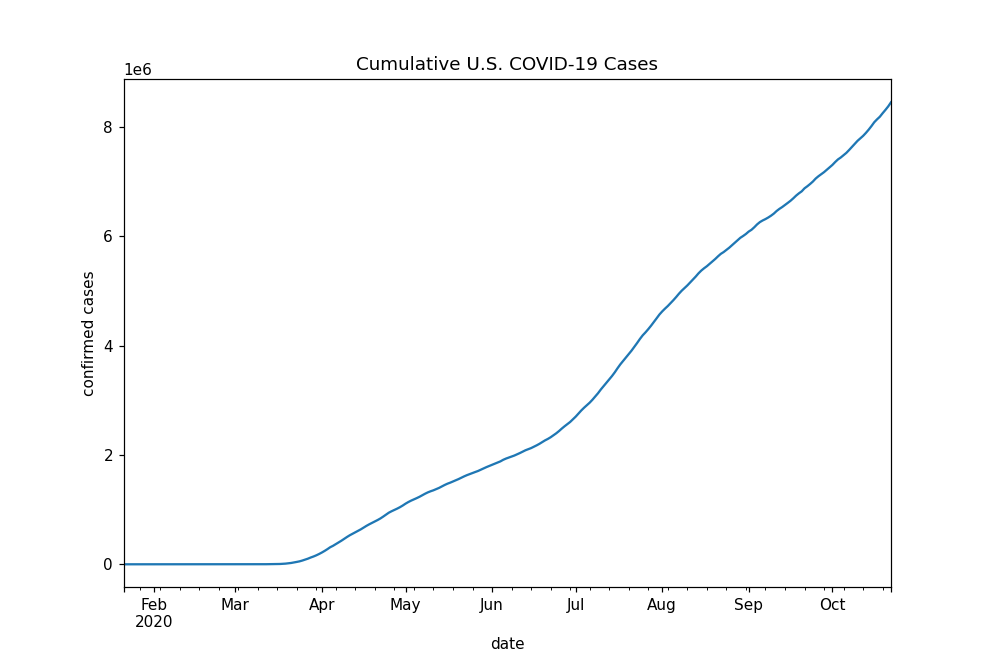

In [94]:
# Group cases by date and sum
cases = df.groupby('date')['cases'].sum()
cases.name = "cumulative cases"

# Ensure the cases index is a DatetimeIndex
cases.index = pd.to_datetime(cases.index)

_ = plot_series(cases, title="Cumulative U.S. COVID-19 Cases")

Note that _cumulative cases_ are the most common smoothing technique for epidemiological modeling because the models assume that recovered individuals have a low likelihood of relapse. Often the study focuses on the $R_0$ value - the number of people an infected person will infect. If $R_0 < 1$ then the epidemic is petering out (hence the flattening of the cumulative cases curve). If $R_0 > 1$ then the pandemic is growing exponentially.

To perform our initial analysis, we will "unsmooth" the cumulative curve back to the daily cases.

<IPython.core.display.Javascript object>


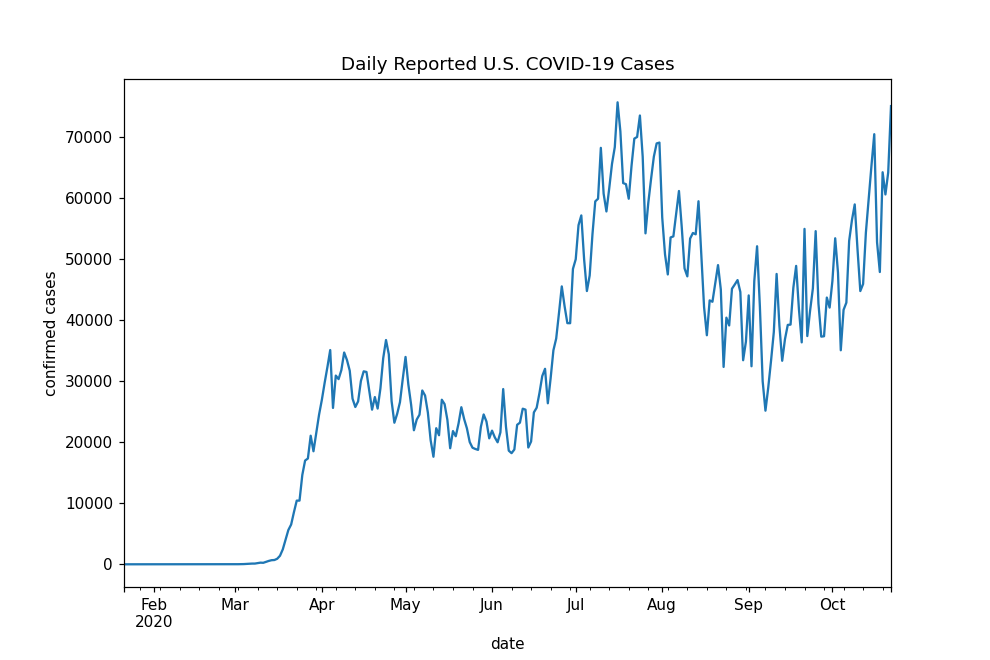

In [95]:
daily_cases = cases.diff().fillna(0)
daily_cases.name = "daily reported cases"
_ = plot_series(daily_cases, title="Daily Reported U.S. COVID-19 Cases")

## Random Walk Analysis

We mentioned in the last class that one of the first things to do with a time series data set was to determine if it is a random walk. We want to identify the following properties:

1. Is there strong temporal dependency that decays linearly?
2. Is the time series non-stationary or does a stationary transformation create no learnable structure?
3. Is the Persistence model the best indicator?

### Autocorrelation

We can use the `autocorrelation_plot` from pandas to conduct a lag correlation analysis over time. This plots the correlation between each observation and the observations at previous time steps across different lag values. This creates a series of 2D scatter plots that the Pearson correlation can be computed on - 1 is strong positive correlation and -1 is strong negative correlation. The series is then plotted with confidence intervals:

In [96]:
from pandas.plotting import autocorrelation_plot as pd_autocorrelation_plot


def autocorrelation_plot(s, ax=None, title=None, legend=False, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
    
    # This is the bulk of the work for this method!
    pd_autocorrelation_plot(s, ax=ax)
    
    if title is not None:
        ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax


_ = autocorrelation_plot(daily_cases)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


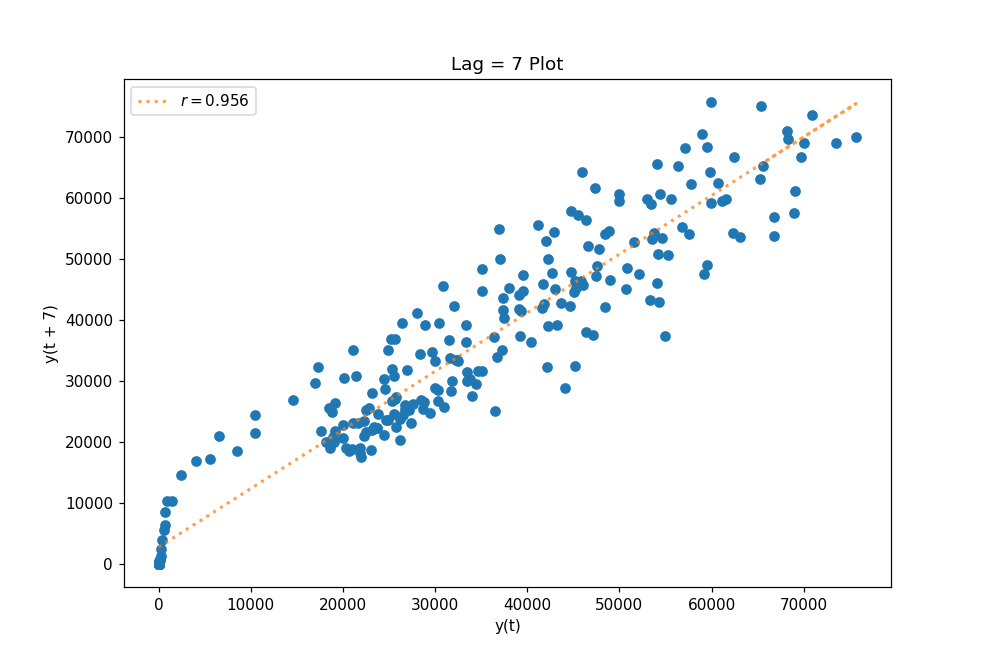

In [97]:
from scipy.stats import pearsonr
from pandas.plotting import lag_plot as pd_lag_plot


def lag_plot(s, lag=1, ax=None, title=None, legend=True, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
    
    # Plot the lag plot
    pd_lag_plot(s, lag=lag, ax=ax)
    
    # Plot the best fit line
    r,_ = pearsonr(s[:-lag], s[lag:])
    m, b = np.polyfit(s[:-lag], s[lag:], 1)
    ax.plot(s[:-lag], m*s[:-lag]+b, label=f"$r={r:0.3f}$", c="C1", ls=":", linewidth=2, alpha=0.75)
    
    title = title or f"Lag = {lag} Plot"
    ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax


_ = lag_plot(daily_cases, 7)

### Stationarity

Stationary time series have values that are not a function of time, e.g. they do not depend on the time when they are observed. They therefore have a consistent mean and variance over time.

We can use the **Augmented Dickey-Fuller Test** to see if a series is stationary. The more negative the ADF, the stronger the rejection of the null hypothesis that a unit root is present (e.g. the more negative the test, the more likely the series is stationary). 

In [98]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(s):
    result = adfuller(s)

    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')

        
adfuller_test(daily_cases)

ADF Statistic: -1.3741962891641613
p-value: 0.594582335719041
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


We can also transform the time series to be stationary by taking the first difference - which stabilizes the mean and reduces trend and seasonality. If there remains no autocorrelation after the stationary transformation, we might think that the time series is a random walk.

<IPython.core.display.Javascript object>


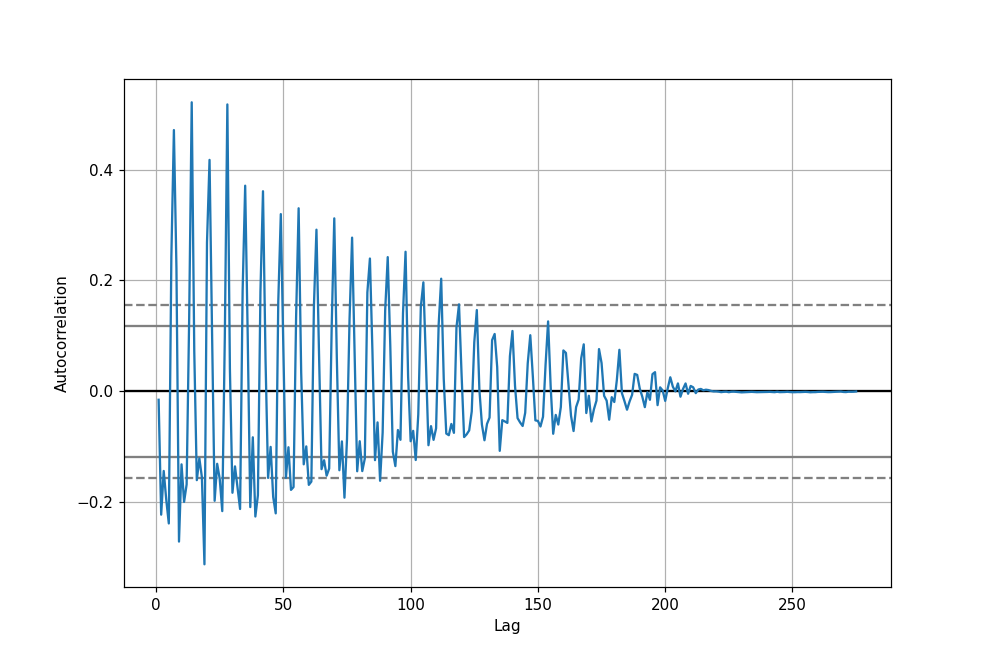

In [99]:
def stationary_transformation(s):   
    sprime = np.zeros(len(s)-1)
    for i in range(1, len(s)):
        sprime[i-1] = s[i]-s[i-1]
    
    return pd.Series(sprime, index=s.index[:-1], name=s.name + " first difference")
    

def stationary_autocorrelation_plot(s, ax=None, title=None, legend=False, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
     
    s = stationary_transformation(s)
    pd_autocorrelation_plot(s, ax=ax)
    
    if title is not None:
        ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax
    
    
_ = stationary_autocorrelation_plot(daily_cases)

### Persistence Model

The simplest time series model is the "persistence model" - a naive model whose prediction for the next observation is identical to the previous prediction. We'll use this as a baseline moving forward and as a way to detect stationarity.

<IPython.core.display.Javascript object>


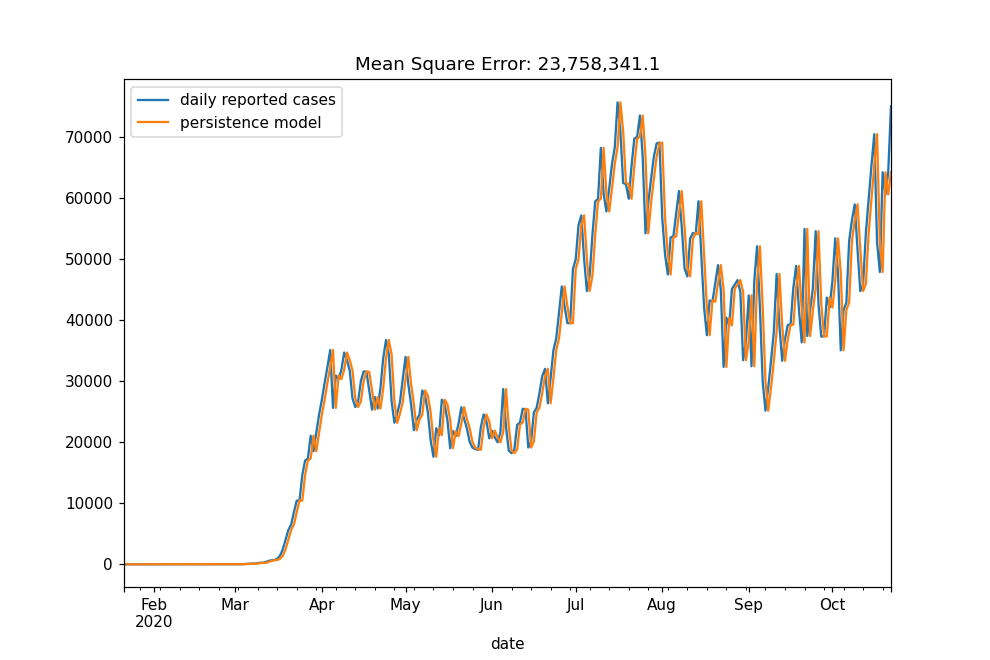

In [161]:
from sklearn.metrics import mean_squared_error


def persistence_model_plot(s, ax=None, title=None, legend=True, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
     
    model = pd.Series(s.values[0:-1], index=s.index[1:], name="persistence model").dropna()
    mse = mean_squared_error(s.values[1:], model)
    
    s.plot(ax=ax)
    model.plot(ax=ax)
    
    title = title or f"Mean Square Error: {mse:0,.1f}"
    ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax
     
    
_ = persistence_model_plot(daily_cases)

## Seasonality Analysis

The next step is to perform a seasonality analysis. There doesn't appear to be much seasonality and we don't have a lot of data, but we'll go through the steps just to confirm our thoughts.

<IPython.core.display.Javascript object>


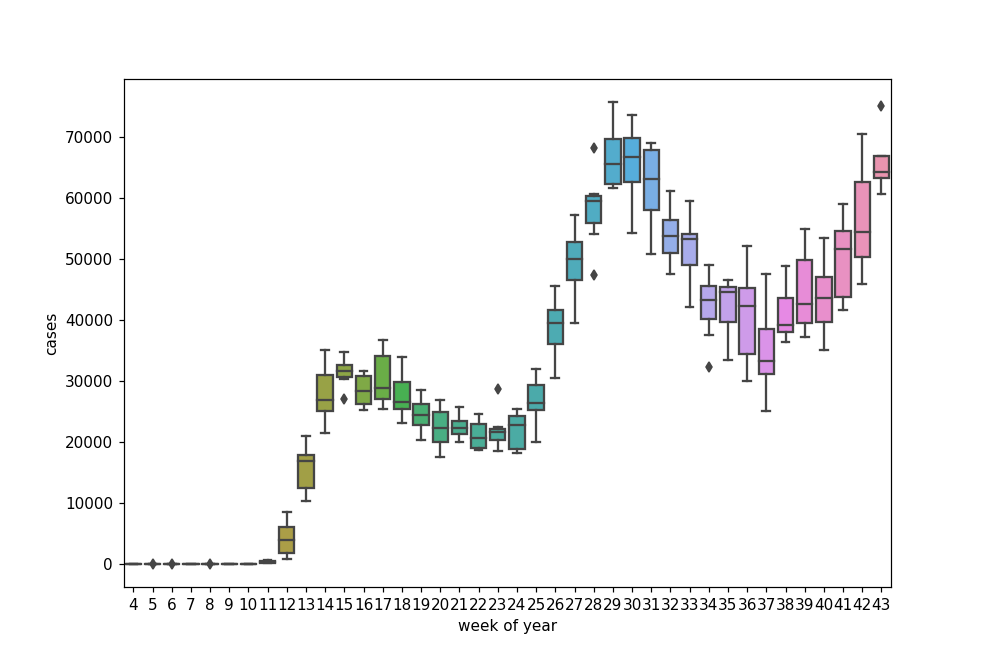

In [116]:
def weekly_boxplot(s, ax=None, title=None, legend=False, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
     
    df = pd.DataFrame(s)
    df["week"] = df.index.isocalendar().week
    
    sns.boxplot(data=df, x="week", y=s.name, ax=ax)
    ax.set_ylabel(kwargs.get("ylabel", "cases"))
    ax.set_xlabel("week of year")
    
    if title:
        ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax
     
    
_ = weekly_boxplot(daily_cases)

<IPython.core.display.Javascript object>


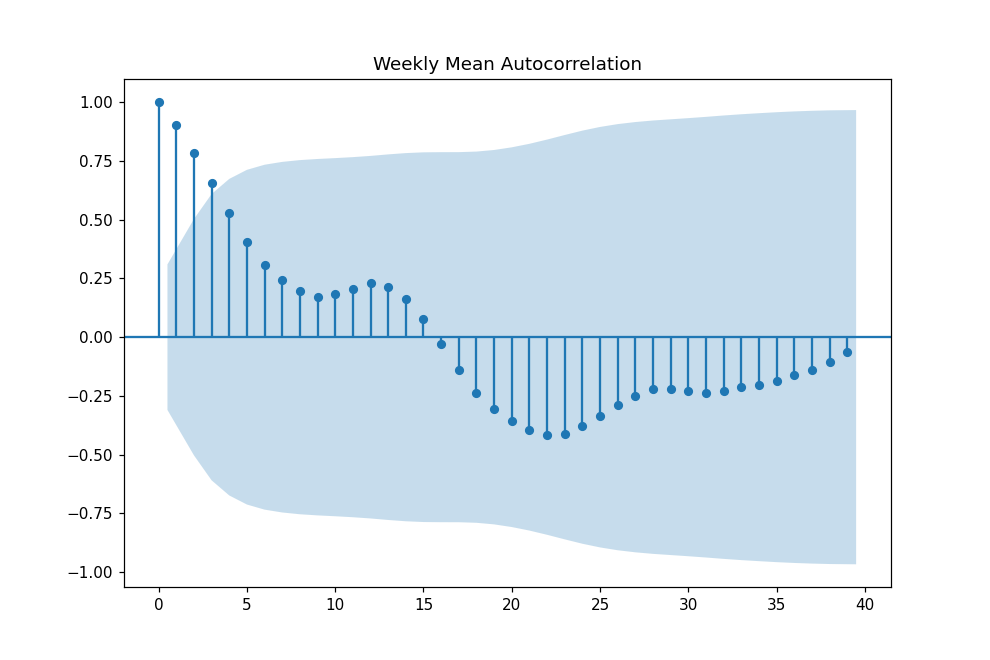

In [122]:
from statsmodels.graphics.tsaplots import plot_acf


def weekly_acf(s, ax=None, title=None, legend=False, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
     
    w = s.resample('W').mean().dropna()
    plot_acf(w.values.squeeze(), lags=min(52, len(w)-1), ax=ax)
    
    title = title or "Weekly Mean Autocorrelation"
    ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax
     
    
_ = weekly_acf(daily_cases)

<IPython.core.display.Javascript object>


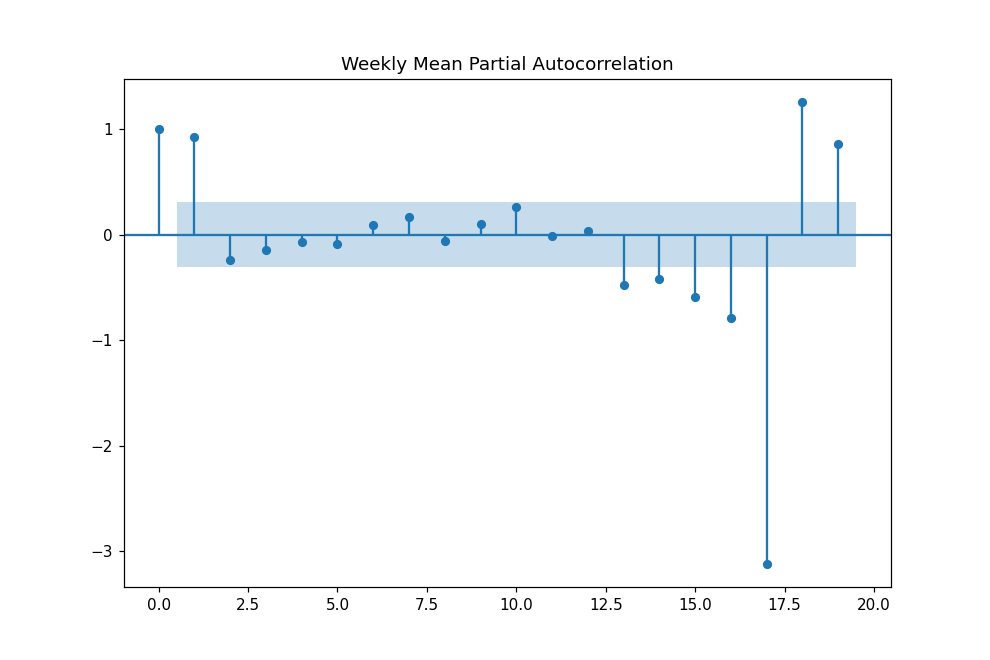

/Users/benjamin/Workspace/georgetown/time-series-analytics/venv/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


In [125]:
from statsmodels.graphics.tsaplots import plot_pacf


def weekly_pacf(s, ax=None, title=None, legend=False, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
     
    w = s.resample('W').mean().dropna()
    plot_pacf(w.values.squeeze(), lags=19, ax=ax)
    
    title = title or "Weekly Mean Partial Autocorrelation"
    ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax
     
    
_ = weekly_pacf(daily_cases)

## Smoothing

We saw how the cumulative data is an excellent smoothing function for epidemiological data. But to complete our analysis we're going to take a look at what the rolling weekly mean and exponential smooth plots might do for our forecasting methods. 

<IPython.core.display.Javascript object>


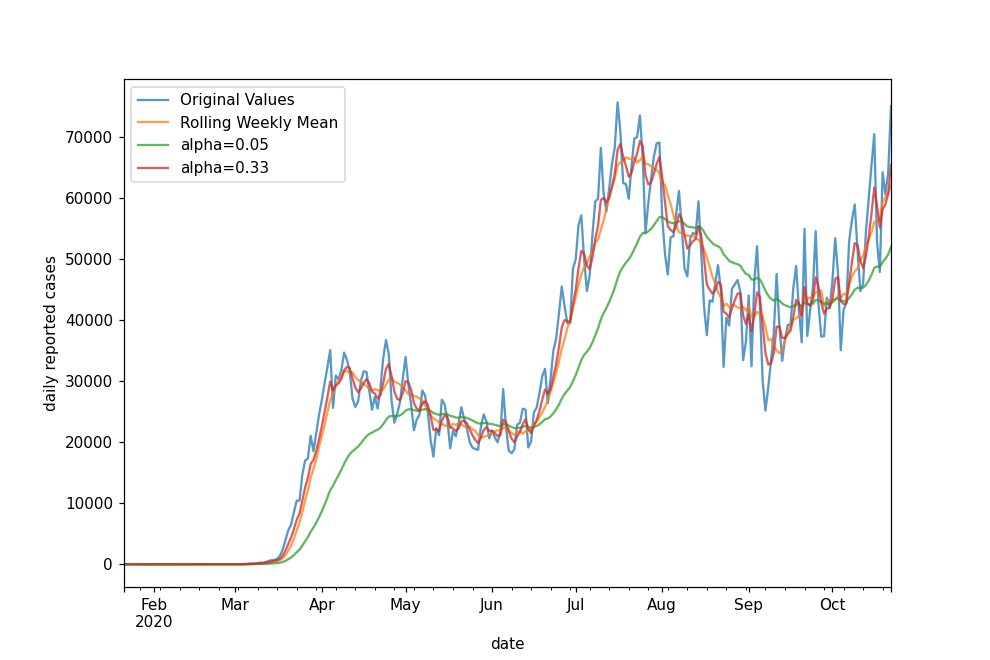

In [132]:
def smoothing_comparison(s, ax=None, title=None, legend=True, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
     
    
    # Plot original
    s.plot(ax=ax, c="C0", label="Original Values", alpha=0.75)
    
    # Plot rolling weekly mean
    s.rolling(window=7).mean().plot(ax=ax, c="C1", label="Rolling Weekly Mean", alpha=0.75)
    
    # Plot exponential smoothing
    s.ewm(alpha=0.05).mean().plot(ax=ax, c="C2", label="alpha=0.05", alpha=0.75)
    s.ewm(alpha=0.33).mean().plot(ax=ax, c="C3", label="alpha=0.33", alpha=0.75)
    
    ax.set_ylabel(kwargs.get("ylabel", s.name))
    
    if title:
        ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax
     
    
_ = smoothing_comparison(daily_cases)

## Forecasting

In this section we'll explore using ARIMA and Holt-Winters to forecast the time series. Next steps would be to use scikit-learn regressions or LSTM or NADE models from TensorFlow or PyTorch. These regressions are beyond the scope of this notebook, however.

The regression will train on the the first part of the data and then attempt to fit the last month of data. Feel free to regress other models as well here!

In [137]:
def train_test_split(s):
    month = (datetime.now() - timedelta(weeks=4)).date()
    return s[:month], s[month:]
    
train, test = train_test_split(daily_cases)

### ARIMA

Our first model will be the ARIMA model. This model is specified by $(p,d,q)$ where $p$ is an autoregressive factor that defines lag, $d$ is the amount of differencing to apply that reduces trend, and $q$ is a moving average that sets error as a linear combination of the previous values. The `SARIMA` modification also includes a second set $(P, D, Q)$ that are similar but for a seasonal regressive component.

<IPython.core.display.Javascript object>


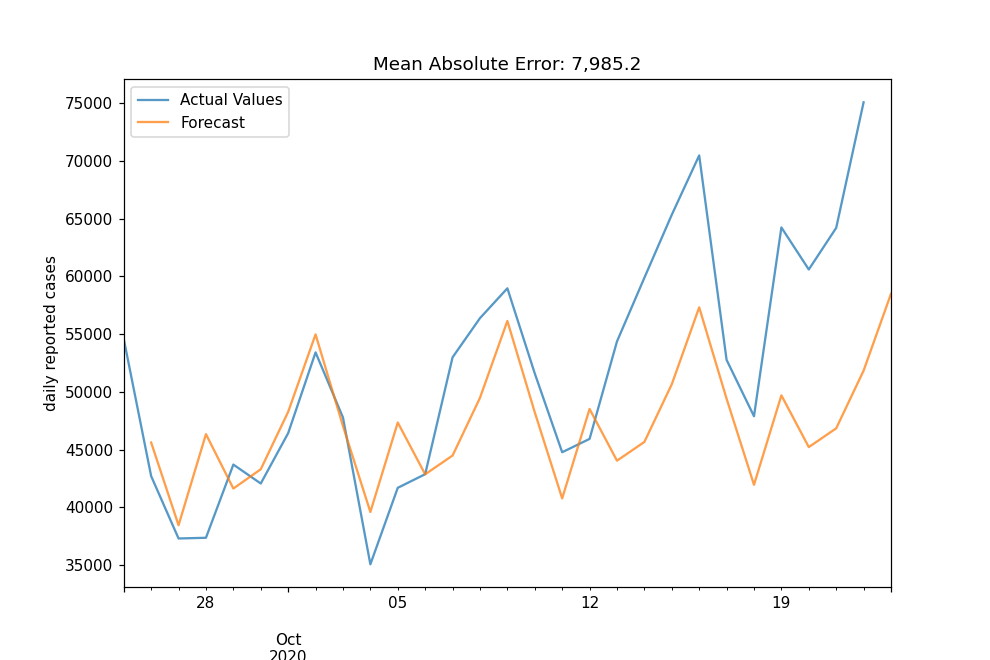

/Users/benjamin/Workspace/georgetown/time-series-analytics/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/benjamin/Workspace/georgetown/time-series-analytics/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/benjamin/Workspace/georgetown/time-series-analytics/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [163]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA


def arima_forecast_plot(train, test, order, ax=None, title=None, legend=True, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
    
    
    # Train the model
    model = ARIMA(train, order=order, **kwargs).fit()
   
    
    # Plot test data
    test.plot(ax=ax, c="C0", label="Actual Values", alpha=0.75)
    
    # Plot forecast data
    yhat = model.forecast(len(test))
    yhat.plot(ax=ax, c="C1", label="Forecast", alpha=0.75)
    
    mae = mean_absolute_error(test, yhat)
    
    ax.set_ylabel(kwargs.get("ylabel", train.name))
    
    title = title or f"Mean Absolute Error: {mae:0,.1f}"
    ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax
     
    
_ = arima_forecast_plot(
    train, test, (1, 1, 1), seasonal_order=(1,1,1,7),
    enforce_stationarity=True, enforce_invertibility=True
)

Questions:

- How would you improve this model?
- How would you tune the model?
- Is this model good or bad?

### Holt-Winters 

Exponential smoothing can be extended to add support for trends in univariate series (double exponential smoothing) and to include support for seasonality (triple exponential smoothing). The Holt Winters method uses triple exponential smoothing to forecast seasonal data by introducing three parameters:

- $\alpha$: smoothing factor for observations
- $\beta$: smoothing factor for the trend
- $\gamma$: influence on seasonal component

Smoothing can be additive or multiplicative.

<IPython.core.display.Javascript object>


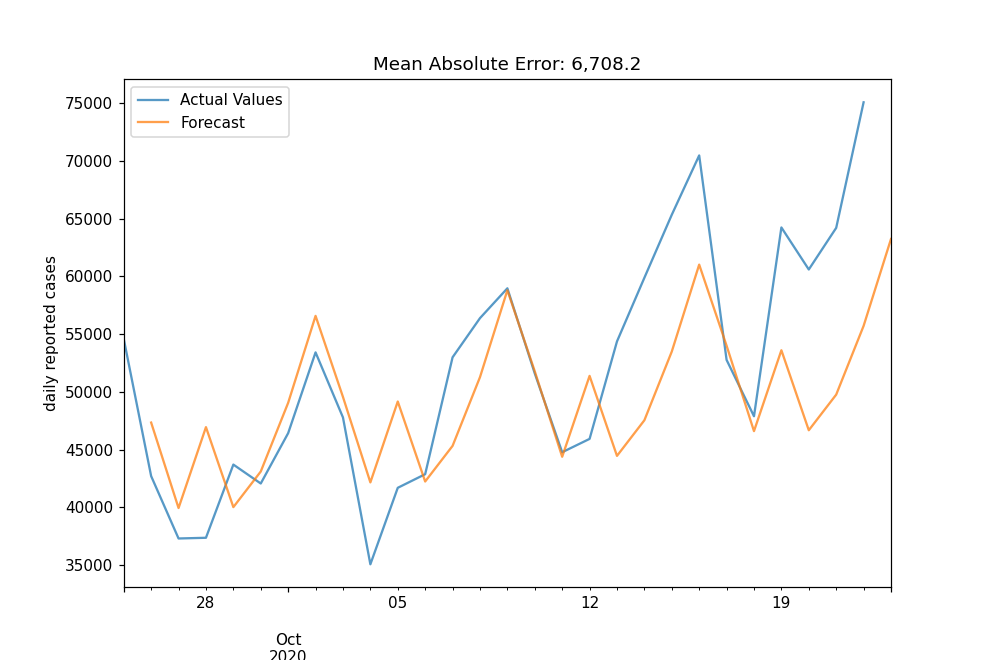

/Users/benjamin/Workspace/georgetown/time-series-analytics/venv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/benjamin/Workspace/georgetown/time-series-analytics/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/Users/benjamin/Workspace/georgetown/time-series-analytics/venv/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


In [167]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import ExponentialSmoothing


def holt_winters_forecast_plot(train, test, seasonal_periods, ax=None, title=None, legend=True, saveto=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=(9,6))
    
    
    # Train the model
    model = ExponentialSmoothing(train, seasonal_periods=seasonal_periods, **kwargs).fit()
   
    
    # Plot test data
    test.plot(ax=ax, c="C0", label="Actual Values", alpha=0.75)
    
    # Plot forecast data
    yhat = model.forecast(len(test))
    yhat.plot(ax=ax, c="C1", label="Forecast", alpha=0.75)
    
    mae = mean_absolute_error(test, yhat)
    
    ax.set_ylabel(kwargs.get("ylabel", train.name))
    
    title = title or f"Mean Absolute Error: {mae:0,.1f}"
    ax.set_title(title)
    
    if legend:
        ax.legend()
    
    if saveto is not None:
        plt.tight_layout()
        plt.savefig(saveto)
    
    return ax
     
    
_ = holt_winters_forecast_plot(
    train, test, 7, trend='add', seasonal='add'
)

## Epidemiological Modeling

Epidemiological models take the form of _compartmental models_ where the population moves through the stages of an infection and while infected can communicate the disease to the rest of the population, which is usually determined through a series of ordinary differential equations. The SEIRU model by Liu et al. Was one of the early COVID-19 models and took the hypothesis that there were two severities patients experienced. The severe cases were reported but the less severe cases were unreported.

The SEIRU model attempts to predict the basic reproduction number, $R_0$ (pronounced "r naught") as well as the unreported cases, and how a single intervention with differential intensity might flatten the curve. The compartments are given as follows:


![SEIRU](figures/22_seiru.png)


Z. Liu, P. Magal, O. Seydi, and G. Webb, “A COVID-19 epidemic model with latency period,” Infectious Disease Modelling, 2020.


The compartmental model is given by the following system of ODEs:

$$
S'(t) = -\tau(t)S(t)[I(t)+U(t)]
$$

$$
E'(t) = \tau(t)S(t)[I(t)+U(t)] - \alpha E(t)
$$

$$
I'(t) = \alpha E(t) - vI(t)
$$

$$
R'(t) = v_1I(t) - \eta R(t)
$$

$$
U'(t) = v_2I(t) - \eta U(t)
$$

Here $S(t)$ is the number of susceptible at time t, $E(t)$ exposed, $I(t)$ infected, $R(t)$ reported, and $U(t)$ unreported. The parameter $\alpha$ is the average duration of the exposed non-infectious period, $v$ the time during which asymptomatic infectious are asymptomatic, and $v_1$ and $v_2$ parameterize how infected become reported or unreported based on $f$ - the faction of each reported and unreported. Finally $\eta$ is the average time of symptoms. The transmission rate is specified by a function $\tau$ as follows:

$$
\tau(t) = \tau_0, 0 \leq t \leq N
$$
$$
\tau(t) = \tau_0 exp(-\mu \times (t-N)), N < t
$$

This function says that the transmission rate is constant until some date, $N$ where an intervention of intensity $\mu$ occurs. 

The model is fitted to the cumulative reported cases, $CR(t)$ by allowing for three free parameters, $\chi$ as follows:

$$
CR(t) = \chi_1exp(\chi_2t)-\chi_3
$$

### Python Model

With some careful translation, we can implement the above ODEs in Python using a systems dynamics model, which uses dynamic programming of a numeric simulation to arbitrarily forward the gradients through time, updating values as they go. For example the function `E` can be implemented as follows:

```python
def E(self, t):
    """
    Computes the number of exposed individuals at time t.
    """
    dE = (self.tau(t-1) * self.S(t-1) * (self.I(t-1) + self.U(t-1)))
    dE -= (self.alpha * self.E(t-1))
    return max(self.E(t-1) + dE, 0)
```

The function is recursive in that it calls the previous time step until `t=0` is reached. This is done with a decorator that steps through the dynamic programming model, but essentially boils down to:

```python
class numsim(object):

    def __init__(self, f, v0):
        self._values = np.asarray([v0])
       
    def __call__(self, t):
        if t >= len(self._values):
            self(t-1)
        return self._values[t]
```

### Fitting Process

The fitting process uses a genetic algorithm to optimize the free parameters $\chi$ and the intensity of the intervention $\mu$. Note that the other variables, $\alpha$, $v$, $f$, and $\eta$ are known by medical observation. The fitness function minimizes mean squared error, though differentiable cost functions are not required for genetic parameter optimization. 


```python
from functools import partial
from scipy.optimize import differential_evolution


def fit_seiru_model(cases, S0, f, v, eta, t0, alpha, return_results=True):
    """
    Uses differential evolution (a genetic parameter optimization method)
    to fit the free variables chi1, chi2, chi3, mu, and N in the SEIRU
    model. A model instantiated with these parameters is returned unless
    return_results=True, in which case the array of parameters is also returned.

    .. todo: document arguments
    """
    ef = partial(seiru_error, cases=cases, S0=S0, f=f, v=v, eta=eta, t0=t0, alpha=alpha)
    bounds = [(-4, 4), (-4, 4), (-4, 4), (-4, 4), (0, len(cases))]
    results = differential_evolution(ef, bounds)

    p = results.x
    model = SEIRU(S0, f, v, eta, t0, p[0], p[1], p[2], alpha, p[3], p[4])

    if return_results:
        return model, results
    return model


def seiru_error(params, cases, S0, f, v, eta, t0, alpha, *args):
    """
    Computes the mean square error of the SEIRU model for the fitted params:
    (chi1, chi2, chi3, mu), using the fixed parameters S0, f, v, eta, alpha, and N.
    The cases variable is the ground truth that the diff is computed from.

    .. todo: document arguments
    """
    model = SEIRU(
        S0, f, v, eta, t0, params[0], params[1], params[2], alpha, params[3], params[4]
    )
    crhat = model.to_dataframe(cases.index, ode="R", cumulative=True)
    return ((crhat["CR"] - cases) ** 2).sum()
```

Unfortunately, I am not yet authorized to share the code for this, but I did fit the model to the case data we've been exploring today, here are the results:

![SEIRU USA Model Fit](figures/23_seiru_usa_fit.png)

Next steps: actual agent based models! This is my current research thrust, doing realistic, non-compartmental simulations for epidemiological modeling. I've included a MESA implementation of SEIRU in the workshop code for you to check out!